# 处理思路

## Preprocessing
包含‘Blogs.csv’和‘Users.csv’两个表的数据，分别表示微博文本和发布者信息。
1. 需要将两个表链接起来，构成一个完整的数据。
2. 时间列进行处理，并且按照时间顺序排序。
3. 对于数据进行标注：即事件发生前/事件发生后；相关讨论/无关讨论。

## NLP preprocessing
对微博文本进行分析。
主要包含 *主题提取* 和 *情感计算* 两个部分。
1. Chinese word segmentation
2. Sentiment score calculation

## Statistics
对于上述处理所得数据进行统计分析。
1. 对于时间序列下发博数、话题相关度，折线图；
2. 讨论条数、热度、不同用户的讨论等。
3. 词云图；

In [18]:
%config IPCompleter.greedy=True

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns


import jieba
import jieba.posseg as pseg
from snownlp import SnowNLP
import nltk
from rake_nltk import Rake
from wordcloud import WordCloud

from numpy.linalg import norm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

# Data Preprocessing

In [3]:
import pandas as pd
import numpy as np
import math

## Blogs

In [4]:
blogs = pd.read_excel('BLOGS.xlsx')

### basic preprocessing

将region字段去除“来自于”，注意存在空值（float type）情况。

In [5]:
def region_processing(region):
    region = str(region) # 对空值特别处理，float->str使得str函数有用
    if len(region) > 0:
        region = region.split()[-1]
    return region

blogs['region'] = blogs['region'].map(region_processing)

In [4]:
blogs.isnull().sum()
blogs.drop_duplicates()
del blogs['comment_api']
del blogs['attitudes_status']

经处理后微博总数有11401条

In [6]:
blogs.weibo_id.count()

11401

去除10个字以下的微博文本。

In [7]:
blogs['lens'] = blogs['text'].map(len)
# 去除过短博文（10个字符以下）
print()
blogs.drop(blogs[blogs['lens']<=10].index, inplace=True)
del blogs['lens']

In [8]:
blogs.weibo_id.count()

11327

### data Labelling

将与issue有关的问题标注出来。

In [9]:
kw_list = ["枪","gun","Gun","Shot", "shot"]

def keyword_detection(text):
    for kw in kw_list:
        if kw in text:
            return 1
    return 0

blogs['relation'] = blogs['text'].apply(keyword_detection)

### 'heat' calculation

根据评论cc、转发rc、点赞数ac计算微博热度。

In [10]:
def heat_cal(row):
    rc = row.repost_count
    cc = row.comments_count
    ac = row.attitudes_count
    heat = - math.log(1 / ((2*rc+2*cc+ac)/5 + 1))
    return heat

blogs['heat'] = blogs.apply(heat_cal, axis=1)

In [11]:
blogs = blogs.drop(blogs.index[[-1,-2]])
del blogs['user_name'], blogs['repost_count'] , blogs['comments_count'] ,blogs['attitudes_count']

In [12]:
blogs.to_excel("blogs_data.xlsx")

# Sentiment Calculation

In [4]:
from paddlenlp import Taskflow
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
df = pd.read_excel("blogs_data.xlsx")
df['created_time'] = df['created_time'].map(pd.to_datetime)

# 将数据按照时间顺序排列
df = df.sort_values(by='created_time')

In [6]:
senta= Taskflow('sentiment_analysis')
def sentacal(text):
    text = text.replace('\u200b','')
    text = text.replace('\n', '')
    return senta(text)[0]['score']

df['sentiment_score'] = df['text'].map(sentacal)

E1203 03:16:53.863092 4220451456 analysis_config.cc:579] Please compile with MKLDNN first to use MKLDNN


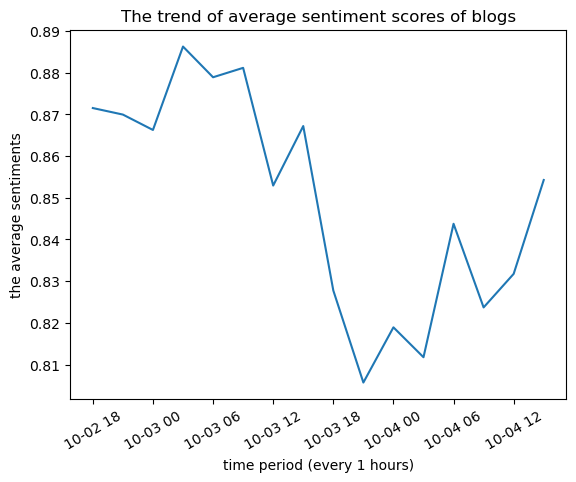

In [7]:
# 将数据按照每3个小时划分
cut_df = df.groupby(pd.Grouper(key='created_time', freq='3H'))
rel_portion = cut_df.relation.sum()/cut_df.weibo_id.count()

avg_emo = cut_df.sentiment_score.mean()

plt.plot(avg_emo)
plt.title("The trend of average sentiment scores of blogs")
plt.xticks(rotation = 30)
plt.xlabel("time period (every 1 hours)")
plt.ylabel("the average sentiments")
plt.savefig('the sentiments trend')

# Statistical Analysis

## proportion of related blogs

In [8]:
# 将数据按照每个小时划分
cut_df = df.groupby(pd.Grouper(key='created_time', freq='3H'))
rel_portion = cut_df.relation.sum()/cut_df.weibo_id.count()

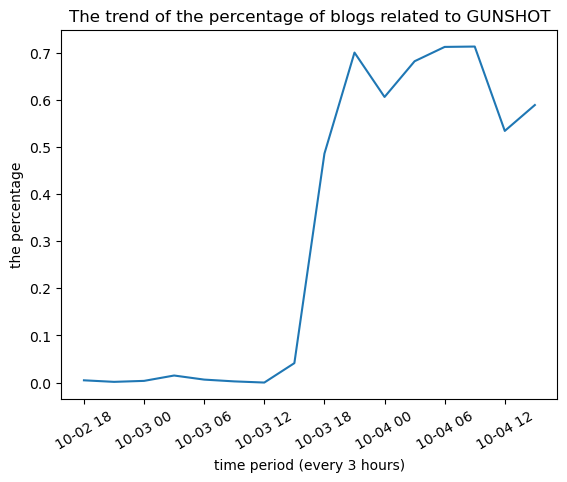

In [9]:
plt.plot(rel_portion)
plt.title("The trend of the percentage of blogs related to GUNSHOT")
plt.xticks(rotation = 30)
plt.xlabel("time period (every 3 hours)")
plt.ylabel("the percentage")
plt.savefig("related_blog_percentage")

# Natural Language Processing

In [10]:
import jieba
import jieba.posseg as pseg
from snownlp import SnowNLP
import nltk
from rake_nltk import Rake
from wordcloud import WordCloud

## CWS

In [11]:
text = df['text'].iloc[-1]

text

'#泰警方对枪击案嫌犯提出5项初步指控# 【泰国警方对曼谷购物中心枪击案嫌犯提出5项初步指控】当地时间10月4日，泰国曼谷京都警察局负责人表示，警方对制造暹罗百丽宫枪击案的嫌犯（男，14岁）提出5项初步指控，分别是蓄意杀人、实施杀人、非法持枪、未经许可携带枪支进入公共场所、未经许可在公共场所 \u200b\u200b\u200b'

In [12]:
# 停用词
base_path = '/Users/antonchekhov/Documents/2023Spring/BA/final/BA_nlp/stopwords/'

stopwords1 = pd.read_csv(base_path + '中文停用词库.txt', encoding="gbk",names=["stopword"])["stopword"].tolist()
stopwords2 = pd.read_csv(base_path + '百度停用词列表.txt', encoding="gbk",names=["stopword"])["stopword"].tolist()
stopwords3 = pd.read_csv(base_path + '四川大学机器智能实验室停用词库.txt',encoding="gbk",names=["stopword"])["stopword"].tolist()
stopwords = stopwords3 + stopwords2 + stopwords1
stopwords.extend(list(';: .)(（）-——①②③④⑤⑥⑦⑧⑨【】#'))

def cut_words_with_pos(text):
    # 将中文空格及换行符替换成英文空格
    text = text.replace("\u200b", ' ')
    text = text.replace("\n", ' ')
    seg = pseg.cut(text)
    res = []
    for i in seg:
        if i.flag in ["a","ad", "n", "an", "vn", "nz", "nt", "nr",'v']:
            res.append(i.word)
    return list(res)

def tokenize(sent, stopwords=stopwords, func=cut_words_with_pos):
    '''
        去停用词+分词操作
        :param sent: 短句文本
        :param func: 分词操作函数
        :param stopwords: 停用词表
        :return: 词语列表
    '''
    # 将句子分割成词语列表
    words = func(sent)
    target_ls = []
    for word in words:
        # 去除停用词
        # 结果中可能包含重复词汇
        if word not in stopwords:
            target_ls.append(word)
    return target_ls

In [13]:
df["tokens"] = df["text"].apply(tokenize)

Building prefix dict from the default dictionary ...
[2023-12-03 03:26:15,673] [   DEBUG] __init__.py:113 - Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/z7/_85qg8c535vfyc7_26cmtdwm0000gn/T/jieba.cache
[2023-12-03 03:26:15,679] [   DEBUG] __init__.py:132 - Loading model from cache /var/folders/z7/_85qg8c535vfyc7_26cmtdwm0000gn/T/jieba.cache
Loading model cost 0.299 seconds.
[2023-12-03 03:26:15,977] [   DEBUG] __init__.py:164 - Loading model cost 0.299 seconds.
Prefix dict has been built successfully.
[2023-12-03 03:26:15,978] [   DEBUG] __init__.py:166 - Prefix dict has been built successfully.


In [14]:
df.head()

,Unnamed: 0,created_time,weibo_id,uid,text,region,attitudes_status,comment_api,relation,heat,sentiment_score,tokens
0,0,2023-10-02 18:00:00+08:00,4952455222922770,6360781999,雨季的泰国，怎么知道马上要下雨了？淋湿了嗓子可要遭罪 ！�️ 当你发现天空变暗，且风也猛烈起...,泰国,0,https://weibo.com/ajax/statuses/buildComments?...,0,0.182322,0.957480,"[下雨, 淋湿, 嗓子, 遭罪, 发现, 天空, 变暗, 风, 猛烈起来, 记得, 路, 步..."
1,1,2023-10-02 18:00:01+08:00,4952455227900380,5174775121,“金翅大鹏”@张立鹏MMA 准备就绪！\n明天出发曼谷打响战斗！\n【比赛预告】：10月7日...,湖南,0,https://weibo.com/ajax/statuses/buildComments?...,0,1.722767,0.984893,"[金翅大, 鹏, 张立鹏, 准备就绪, 出发, 打响, 比赛, 预告, 巅峰, 系列赛, 综..."
2,2,2023-10-02 18:01:00+08:00,4952455476155020,6179910550,#微博变美手册# #日常# #明星同款# \n盲猜这组穿搭会�赵露思泰国穿搭 ​​​,天津,0,https://weibo.com/ajax/statuses/buildComments?...,0,3.879500,0.941789,"[博变, 手册, 明星, 同款, 猜, 组穿, 搭会, 赵露思, 穿, 搭]"
3,3,2023-10-02 18:01:30+08:00,4952455600935650,7495998578,#Lisa被拍与三公子聚餐#\nlisa现在的状态很符合我对泰国的印象 ​​​,黑龙江,0,https://weibo.com/ajax/statuses/buildComments?...,0,0.955511,0.882111,"[拍, 公子, 聚餐, 状态, 符合, 印象]"
4,4,2023-10-02 18:01:46+08:00,4952455667779830,5024925921,#泰国娱乐# Aom为男友HisoAmp庆生。。生日快乐！[蛋糕][蛋糕][鲜花][鲜花] ​​​,泰国,0,https://weibo.com/ajax/statuses/buildComments?...,0,3.583519,0.994519,"[娱乐, 男友, 庆生, 蛋糕, 蛋糕, 鲜花, 鲜花]"


## Wordcloud

In [30]:
cut_df.groups

{Timestamp('2023-10-02 18:00:00+0800', tz='UTC+08:00'): 632,
 Timestamp('2023-10-02 21:00:00+0800', tz='UTC+08:00'): 1311,
 Timestamp('2023-10-03 00:00:00+0800', tz='UTC+08:00'): 1593,
 Timestamp('2023-10-03 03:00:00+0800', tz='UTC+08:00'): 1660,
 Timestamp('2023-10-03 06:00:00+0800', tz='UTC+08:00'): 1820,
 Timestamp('2023-10-03 09:00:00+0800', tz='UTC+08:00'): 2227,
 Timestamp('2023-10-03 12:00:00+0800', tz='UTC+08:00'): 2681,
 Timestamp('2023-10-03 15:00:00+0800', tz='UTC+08:00'): 3166,
 Timestamp('2023-10-03 18:00:00+0800', tz='UTC+08:00'): 4349,
 Timestamp('2023-10-03 21:00:00+0800', tz='UTC+08:00'): 5892,
 Timestamp('2023-10-04 00:00:00+0800', tz='UTC+08:00'): 6715,
 Timestamp('2023-10-04 03:00:00+0800', tz='UTC+08:00'): 6951,
 Timestamp('2023-10-04 06:00:00+0800', tz='UTC+08:00'): 7633,
 Timestamp('2023-10-04 09:00:00+0800', tz='UTC+08:00'): 9203,
 Timestamp('2023-10-04 12:00:00+0800', tz='UTC+08:00'): 10283,
 Timestamp('2023-10-04 15:00:00+0800', tz='UTC+08:00'): 11325}

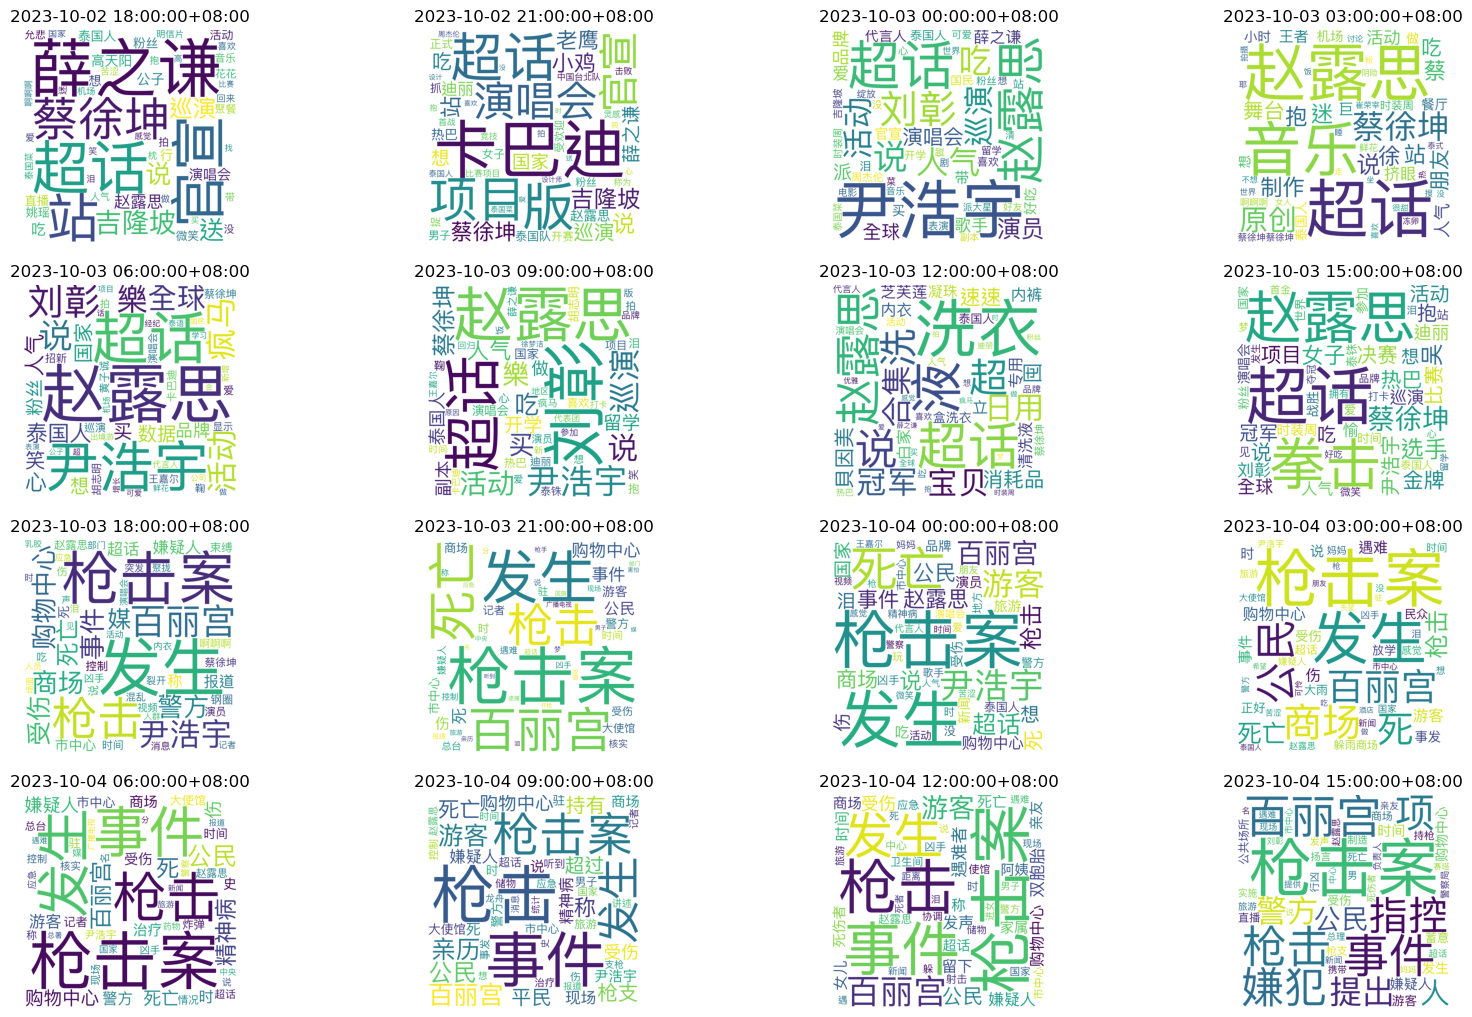

In [32]:
count = 0
plt.figure(figsize=(20,16))

for name,group in cut_df:
    texts = ""
    count += 1
    for row in group.itertuples():
        text = row.text
        texts += " ".join(tokenize(text, stopwords, cut_words_with_pos))

    r = Rake()
    r.extract_keywords_from_text(texts)
    words_dist = r.get_word_frequency_distribution() # 词分布
    sorted_ls = sorted(words_dist.items(), key=lambda x:x[1], reverse=True)[:50] # 取前50个词
    top_words_dist = dict(sorted_ls)
    wc = WordCloud(background_color='white',#背景颜色（这里为白色）
                   font_path="/System/Library/fonts/PingFang.ttc",
                   width = 1000, 
                   height = 1000,
                   max_font_size = 300,
                 ).generate_from_frequencies(top_words_dist) #绘制词云图
    plt.subplot(5,4,count)
    plt.title(name)
    plt.imshow(wc)
    plt.axis('off')

plt.savefig("blogs_wordcloud.png")
plt.show()

## topic extraction by GSDMM

In [33]:
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gsdmm import MovieGroupProcess

In [34]:
texts = [row.tokens for row in df.itertuples()]
dictionary = corpora.Dictionary(texts)

# 从字典中过滤极端情况
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# dictionary.filter_n_most_frequent()
corpus = [dictionary.doc2bow(t) for t in texts]

# 获取字典长度
vocab_length = len(dictionary)

In [35]:
# 初始化GSDMM
gsdmm = MovieGroupProcess(K=15, alpha=0.1, beta=0.3, n_iters=15)

# 拟合GSDMM模型
y = gsdmm.fit(texts, vocab_length)

In stage 0: transferred 10024 clusters with 15 clusters populated
In stage 1: transferred 4754 clusters with 15 clusters populated
In stage 2: transferred 2344 clusters with 15 clusters populated
In stage 3: transferred 1798 clusters with 15 clusters populated
In stage 4: transferred 1587 clusters with 15 clusters populated
In stage 5: transferred 1451 clusters with 15 clusters populated
In stage 6: transferred 1416 clusters with 15 clusters populated
In stage 7: transferred 1393 clusters with 15 clusters populated
In stage 8: transferred 1350 clusters with 15 clusters populated
In stage 9: transferred 1364 clusters with 15 clusters populated
In stage 10: transferred 1281 clusters with 15 clusters populated
In stage 11: transferred 1314 clusters with 15 clusters populated
In stage 12: transferred 1307 clusters with 15 clusters populated
In stage 13: transferred 1247 clusters with 15 clusters populated
In stage 14: transferred 1262 clusters with 15 clusters populated


In [42]:
# 打印每个主题的文档数
doc_count = np.array(gsdmm.cluster_doc_count)
print('Number of documents per topic :', doc_count)

# 按分配给主题的文档数排序的主题
top_index = doc_count.argsort()[-6:][::-1]
print('Most important clusters (by number of docs inside):', top_index)

# 定义函数以获取每个主题的热门单词
def top_words(cluster_word_distribution, top_cluster, values):
    for cluster in top_cluster:
        sort_dicts = sorted(cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print("\nCluster %s : %s"%(cluster, sort_dicts))

# 获取主题中的热门单词
top_words(gsdmm.cluster_word_distribution, top_index, 15)

Number of documents per topic : [ 316  458  377  288 1185  359  750 1029  867  317  514  452  616  938
 2859]
Most important clusters (by number of docs inside): [14  4  7 13  8  6]

Cluster 14 : [('枪击案', 2097), ('发生', 1681), ('百丽宫', 1119), ('死亡', 800), ('商场', 790), ('游客', 783), ('枪击', 712), ('事件', 568), ('说', 357), ('旅游', 295), ('泪', 294), ('亲历', 272), ('枪', 189), ('国家', 177), ('想', 171)]

Cluster 4 : [('超话', 267), ('说', 249), ('想', 206), ('泰国人', 144), ('泪', 144), ('啊啊啊', 138), ('苦涩', 126), ('微笑', 104), ('笑', 97), ('喜欢', 85), ('没', 83), ('爱', 72), ('粉丝', 70), ('做', 67), ('朋友', 66)]

Cluster 7 : [('枪击', 1378), ('枪击案', 1131), ('事件', 1100), ('公民', 1094), ('购物中心', 995), ('百丽宫', 933), ('发生', 789), ('死', 662), ('受伤', 606), ('伤', 578), ('游客', 560), ('死亡', 512), ('市中心', 477), ('驻', 451), ('大使馆', 443)]

Cluster 13 : [('枪击案', 1224), ('事件', 578), ('枪击', 554), ('百丽宫', 538), ('嫌疑人', 509), ('购物中心', 396), ('死亡', 381), ('警方', 370), ('精神病', 363), ('发生', 353), ('受伤', 329), ('时', 303), ('游客', 292), ('商场

In [46]:
total_doc_num = gsdmm.number_docs
predict_label = np.zeros((total_doc_num,), dtype=int)
for i in range(len(texts)):
    pre = gsdmm.choose_best_label(texts[i])[0]
    result = -1
    if pre in [12,7,13]:
        result = 0
    if pre == 4:
        result = 1
    if pre == 8:
        result = 3
    if pre == 6:
        result = 2
    predict_label[i] = result

In [47]:
df['topic'] = predict_label

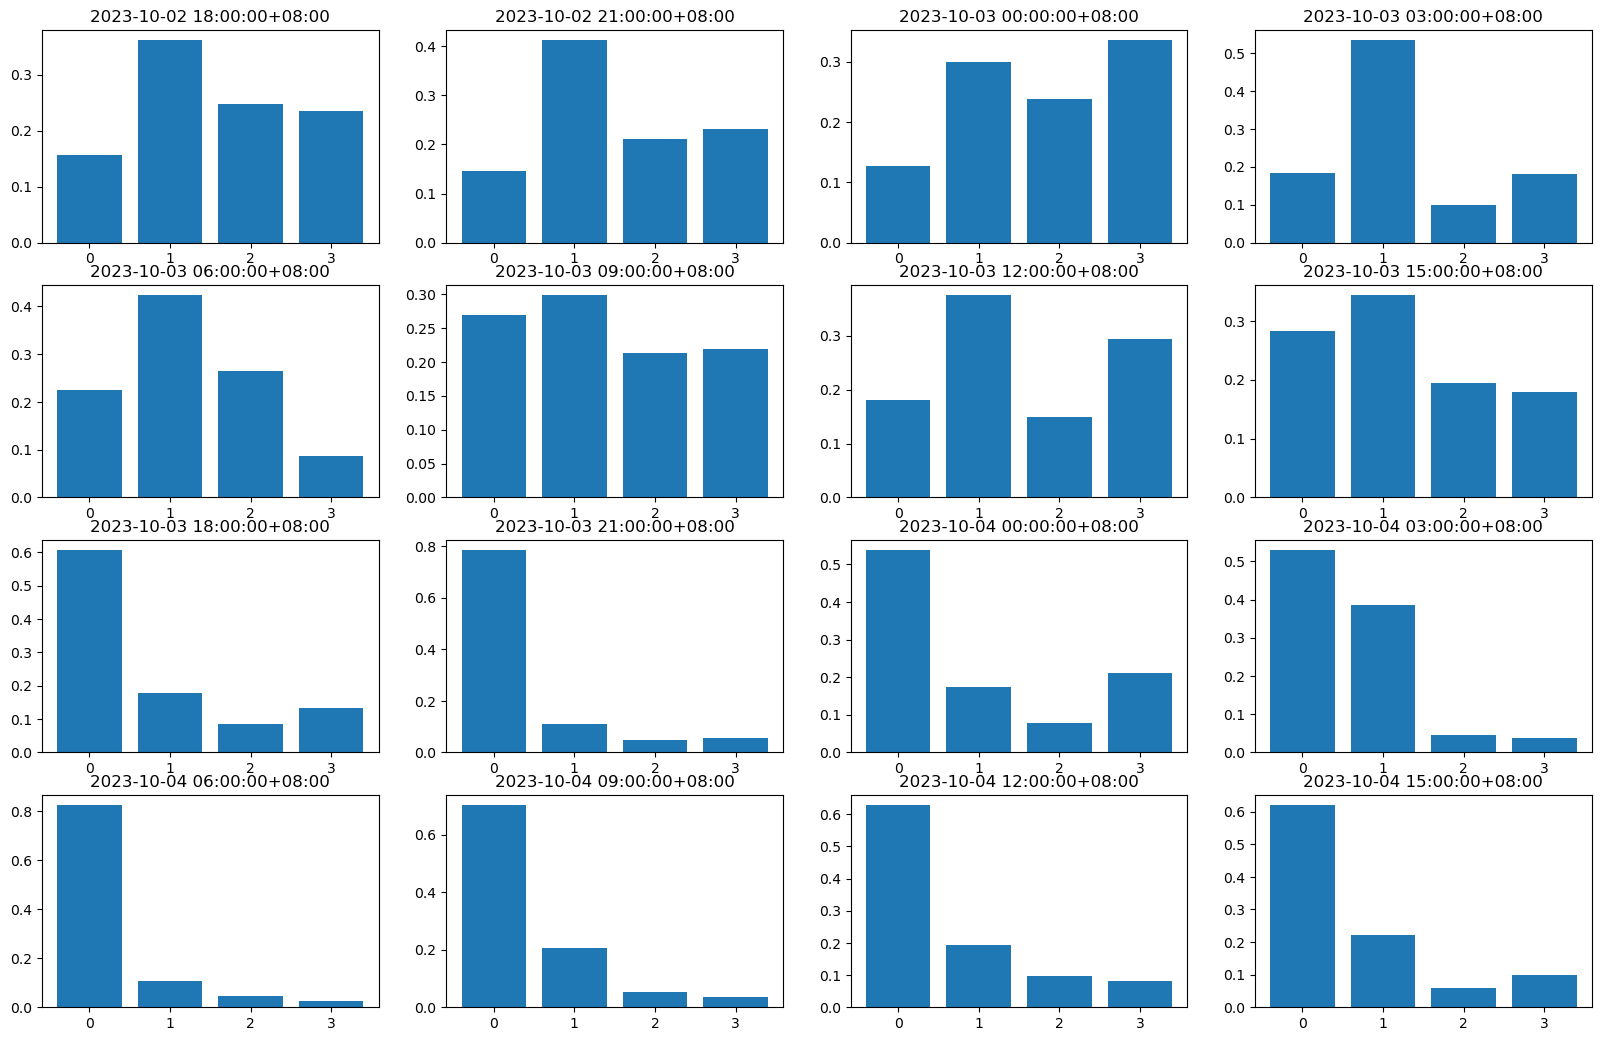

In [48]:
cut_df = df.groupby(pd.Grouper(key='created_time', freq='3H'))
count = 0
plt.figure(figsize=(20,16))


for name, group in cut_df:
    count += 1
    tpc_heat = [0] * 4
    for row in group.itertuples():
        i = row.topic
        if i >= 0:
            tpc_heat[i] += row.heat
    x = [i for i in range(4)]
    tpc_heat = [i/sum(tpc_heat) for i in tpc_heat]
    #tpc_cnt = group.topic.value_counts()
    #x = tpc_cnt.index
    #y = tpc_cnt.to_numpy()
    plt.subplot(5,4,count)
    plt.title(name)
    plt.bar(x, height=tpc_heat)
    plt.axis('on')
plt.savefig('topic_distribution')
plt.show()

## TF-IDF

In [21]:
from numpy.linalg import norm
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np

In [22]:
tfidfVect_map = {}
total_text = [row.tokens for row in df.itertuples()]
docs = [" ".join(r) for r in total_text]
tfidf_model = TfidfVectorizer().fit(docs) # 拟合模型
sparse_result = tfidf_model.transform(docs)
w = sparse_result.todense() # tf-idf矩阵
voc = tfidf_model.vocabulary_ # 包含的词语

计算两个词语见相似度示例：

In [23]:
i1 = voc["枪击案"]
vec1 = np.asarray(w[:,i1])

i2 = voc["枪击"]
vec2 = np.asarray(w[:,i2])

cosine = np.dot(vec1.T,vec2)/(norm(vec1)*norm(vec2))
print("余弦相似度:", cosine)

余弦相似度: [[0.17062839]]


## Dimension Reduction
### PCA

In [24]:
# 将np.matrix格式的w转化为np.array
W = np.asarray(w)

# 将W进行PCA降维
# W的每一行表示一条微博，labels表示是否与issue相关
pca = PCA(n_components=5)
X = pca.fit_transform(W)
labels = labels = df.relation

kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X)
preY = kmeans.labels_


accuracy_score(labels,preY)

0.7811037527593819

## T-SNE

In [26]:
from sklearn.manifold import TSNE

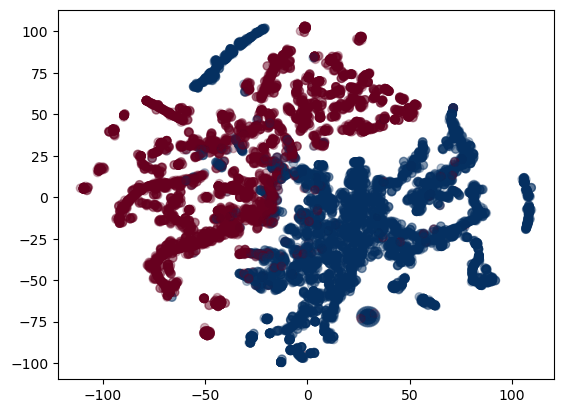

In [27]:
# 将W进行PCA降维
# W的每一行表示一条微博，labels表示是否与issue相关
from sklearn import preprocessing
from sklearn.decomposition import PCA
X_std = preprocessing.scale(X)

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_std)

plt.scatter(X_tsne[:,0],X_tsne[:,1],c=labels,alpha=0.3,cmap = plt.cm.RdBu_r)
plt.savefig('tsne1.png')

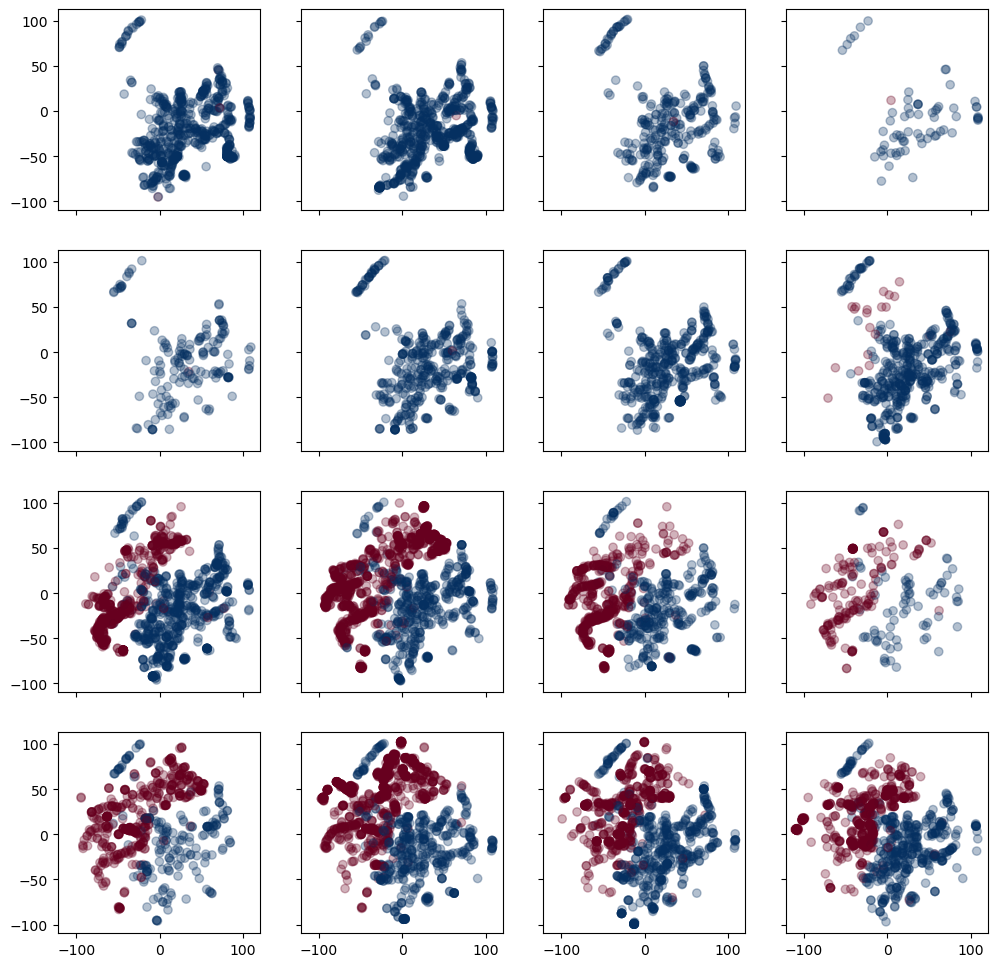

In [28]:
df['x1'] = X_tsne[:,0]
df['x2'] = X_tsne[:,1]

fig, axs = plt.subplots(4, 4, sharey=True,sharex=True, figsize = (12,12))

for i, (name, group) in enumerate(df.groupby(pd.Grouper(key='created_time', freq='3H'))):
    m = i // 4
    n = i % 4
    axs[m,n].scatter(group.x1,group.x2,c=group.relation,alpha=0.3,cmap = plt.cm.RdBu_r)

plt.savefig('tsne2.png')